In [1]:
# **Fine-Tune gaborcselle/font-identifier for Comic Sans vs Not Comic Sans**
!pip install transformers torch torchvision

In [2]:
# 1. Load the pre-trained model and processor
import random
import torch
import numpy as np
from transformers import AutoImageProcessor, AutoModelForImageClassification
import torch.nn as nn

# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load the model and processor
processor = AutoImageProcessor.from_pretrained("gaborcselle/font-identifier")
model = AutoModelForImageClassification.from_pretrained("gaborcselle/font-identifier")

# Modify the final classification layer for binary output and add Dropout
model.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Dropout(0.3),  # Add Dropout for regularization
    nn.Linear(model.classifier[1].in_features, 2)  # 2-class output
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBasicLayer(
              (shortcut): Identity()
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                  (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  (activation): ReLU()
           

In [3]:
# Section 2: Dataset Preparation with Correct Label Mapping
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Dataset path
# /data/comic and /data/not-comic
data_dir = "./data"

# Apply augmentations and normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset with target_transform to fix flipped labels
full_dataset = datasets.ImageFolder(
    data_dir, 
    transform=transform,
    target_transform=lambda x: 1 - x  # Flip the labels: 0 -> 1, 1 -> 0
)

# Verify class-to-index mapping
print(f"Class-to-Index Mapping: {full_dataset.class_to_idx}")

# Train/Validation Split
train_size = int(0.8 * len(full_dataset))  # 80% train, 20% validation
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Dataloaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


Class-to-Index Mapping: {'comic': 0, 'not-comic': 1}


In [4]:
# 3. Fine-Tuning: Optimizer with weight decay and learning rate scheduler
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-4)  # L2 regularization
criterion = nn.CrossEntropyLoss()

# Learning rate scheduler with increased patience
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)


In [5]:
# 4. Training Loop with Scheduler and Regularization
epochs = 20
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(imgs).logits
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            logits = model(imgs).logits
            val_loss += criterion(logits, labels).item()
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    scheduler.step(val_loss / len(val_loader))  # Adjust learning rate

    print(f"Epoch {epoch+1}: Train Loss={total_loss/len(train_loader):.4f}, "
          f"Val Loss={val_loss/len(val_loader):.4f}, Accuracy={correct/total:.2%}")


Epoch 1: Train Loss=0.8030, Val Loss=0.6054, Accuracy=55.88%
Epoch 2: Train Loss=0.5283, Val Loss=0.4614, Accuracy=70.59%
Epoch 3: Train Loss=0.4676, Val Loss=0.4071, Accuracy=67.65%
Epoch 4: Train Loss=0.4014, Val Loss=0.3437, Accuracy=79.41%
Epoch 5: Train Loss=0.3075, Val Loss=0.4189, Accuracy=70.59%
Epoch 6: Train Loss=0.2280, Val Loss=0.4556, Accuracy=70.59%
Epoch 7: Train Loss=0.2089, Val Loss=0.4277, Accuracy=76.47%
Epoch 8: Train Loss=0.1300, Val Loss=0.3871, Accuracy=76.47%
Epoch 9: Train Loss=0.1979, Val Loss=0.4261, Accuracy=73.53%
Epoch 10: Train Loss=0.1126, Val Loss=0.4501, Accuracy=76.47%
Epoch 11: Train Loss=0.1359, Val Loss=0.3841, Accuracy=79.41%
Epoch 12: Train Loss=0.0813, Val Loss=0.3953, Accuracy=79.41%
Epoch 13: Train Loss=0.0825, Val Loss=0.3310, Accuracy=79.41%
Epoch 14: Train Loss=0.1268, Val Loss=0.4192, Accuracy=82.35%
Epoch 15: Train Loss=0.0658, Val Loss=0.4796, Accuracy=73.53%
Epoch 16: Train Loss=0.0567, Val Loss=0.5067, Accuracy=76.47%
Epoch 17: Train L

In [8]:
# 4. Save Fine-Tuned Model
model.save_pretrained("./")
processor.save_pretrained("./")

['./preprocessor_config.json']

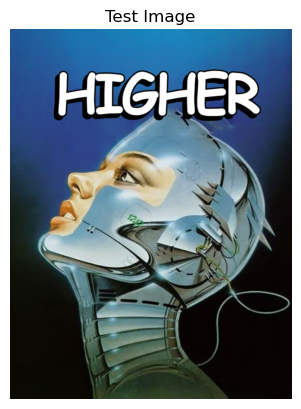

Likelihood of Comic Sans: 99.80%


In [9]:
# 5. Inference Example: Test on a Single Image
from PIL import Image  # Ensure PIL is imported
import matplotlib.pyplot as plt

# Load and display the image
image_path = "./data/comic/test_sample.png"  # Replace with the path to your test image
image = Image.open(image_path).convert("RGB")  # Open and convert the image to RGB

# Display the image in Jupyter Notebook
plt.imshow(image)
plt.axis('off')  # Turn off axes
plt.title("Test Image")
plt.show()

# Preprocess the image for the model
inputs = processor(images=image, return_tensors="pt").to(device)

# Run inference
model.eval()
with torch.no_grad():
    outputs = model(**inputs).logits
    probs = torch.softmax(outputs, dim=-1)
    comic_prob = probs[0][1].item()  # Class index 1 for "Comic Sans"

# Print likelihood of Comic Sans
print(f"Likelihood of Comic Sans: {comic_prob:.2%}")
